# 2.6 Class Activation Map

## Tensorflow Walkthrough

### 1. Import Dependencies

In [1]:
import os

from tensorflow.examples.tutorials.mnist import input_data
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.python.ops import nn_ops, gen_nn_ops
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

from models.models_2_6 import MNIST_CNN
from utils import find_roi

%matplotlib inline

mnist_cluttered = np.load('./MNIST_cluttered/mnist_sequence1_sample_5distortions5x5.npz')
X_train = mnist_cluttered['X_train']
y_train = mnist_cluttered['y_train']
X_valid = mnist_cluttered['X_valid']
y_valid = mnist_cluttered['y_valid']
X_test = mnist_cluttered['X_test']
y_test = mnist_cluttered['y_test']

logdir = './tf_logs/2_6_CAM/'
ckptdir = logdir + 'model'

if not os.path.exists(logdir):
    os.mkdir(logdir)

### 2. Building Graph

In [2]:
with tf.name_scope('Classifier'):

    # Initialize neural network
    DNN = MNIST_CNN('CNN')

    # Setup training process
    X = tf.placeholder(tf.float32, [None, 1600], name='X')
    Y = tf.placeholder(tf.int64, [None], name='Y')
    Y_hot = tf.one_hot(Y, 10)

    activations, logits = DNN(X)
    
    tf.add_to_collection('CAM', X)
    
    for activation in activations:
        tf.add_to_collection('CAM', activation)

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y_hot))

    optimizer = tf.train.AdamOptimizer().minimize(cost, var_list=DNN.vars)

    correct_prediction = tf.equal(tf.argmax(logits, 1), Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

cost_summary = tf.summary.scalar('Cost', cost)
accuray_summary = tf.summary.scalar('Accuracy', accuracy)
summary = tf.summary.merge_all()

### 3. Training Network

In [3]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# Hyper parameters
training_epochs = 20
batch_size = 100

for epoch in range(training_epochs):
    total_batch = int(np.shape(X_train)[0] / batch_size)
    avg_cost = 0
    avg_acc = 0
    
    for i in range(total_batch):
        batch_xs, batch_ys = X_train[i * batch_size:(i+1) * batch_size], y_train[i * batch_size:(i+1) * batch_size].reshape([-1])
        _, c, a, summary_str = sess.run([optimizer, cost, accuracy, summary], feed_dict={X: batch_xs, Y: batch_ys})
        avg_cost += c / total_batch
        avg_acc += a / total_batch
        
        file_writer.add_summary(summary_str, epoch * total_batch + i)

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost), 'accuracy =', '{:.9f}'.format(avg_acc))
    
    saver.save(sess, ckptdir)

print('Accuracy:', sess.run(accuracy, feed_dict={X: X_test, Y: y_test.reshape([-1])}))

sess.close()

Epoch: 0001 cost = 2.033042523 accuracy = 0.242500000
Epoch: 0002 cost = 1.390657289 accuracy = 0.534400000
Epoch: 0003 cost = 1.008045424 accuracy = 0.682800002
Epoch: 0004 cost = 0.793261112 accuracy = 0.747399999
Epoch: 0005 cost = 0.669011008 accuracy = 0.789900001
Epoch: 0006 cost = 0.583145978 accuracy = 0.816799999
Epoch: 0007 cost = 0.521201497 accuracy = 0.835999998
Epoch: 0008 cost = 0.473216166 accuracy = 0.851299996
Epoch: 0009 cost = 0.434501152 accuracy = 0.865799996
Epoch: 0010 cost = 0.402649050 accuracy = 0.875399997
Epoch: 0011 cost = 0.375527744 accuracy = 0.886000000
Epoch: 0012 cost = 0.351153830 accuracy = 0.894500001
Epoch: 0013 cost = 0.329674218 accuracy = 0.901000003
Epoch: 0014 cost = 0.310661063 accuracy = 0.906300002
Epoch: 0015 cost = 0.293649128 accuracy = 0.911300003
Epoch: 0016 cost = 0.278376295 accuracy = 0.916400003
Epoch: 0017 cost = 0.265304229 accuracy = 0.919800004
Epoch: 0018 cost = 0.253397216 accuracy = 0.922400003
Epoch: 0019 cost = 0.2428286

### 4. Restoring Subgraph

In [4]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

new_saver = tf.train.import_meta_graph(ckptdir + '.meta')
new_saver.restore(sess, tf.train.latest_checkpoint(logdir))

activations = tf.get_collection('CAM')
weights = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='.*kernel.*')

X = activations[0]
activations = activations[1:]

sample_imgs = [X_train[y_train.reshape([-1]) == i][5] for i in range(10)]

INFO:tensorflow:Restoring parameters from ./tf_logs/2_6_CAM/model


### 5. Generating CAM

In [5]:
hmap_ind = 1
img_ind = 1

conv_ksize = [1, 3, 3, 1]
pool_ksize = [1, 2, 2, 1]
conv_strides = [1, 1, 1, 1]
pool_strides = [1, 2, 2, 1]

cams = []

for i in range(128):

    rect3 = activations[5][:, :, :, None, i]
    derect3 = tf.nn.relu(rect3)
    deconv3 = tf.nn.conv2d_transpose(derect3, weights[2][:, :, :, None, i], tf.shape(activations[4]), conv_strides, 'SAME')

    depool2 = nn_ops.max_pool_grad_v2(activations[3], activations[4], deconv3, pool_ksize, pool_strides, 'SAME')
    derect2 = tf.nn.relu(depool2)
    deconv2 = tf.nn.conv2d_transpose(derect2, weights[1], tf.shape(activations[2]), conv_strides, 'SAME')

    depool1 = nn_ops.max_pool_grad_v2(activations[1], activations[2], deconv2, pool_ksize, pool_strides, 'SAME')
    derect1 = tf.nn.relu(depool1)
    deconv1 = tf.nn.conv2d_transpose(derect1, weights[0], tf.shape(activations[0]), conv_strides, 'SAME')

    r = sess.run(deconv1, feed_dict={X: sample_imgs})
    cams.append(r)

w = sess.run(weights[-1], feed_dict={X: sample_imgs})

hmaps = np.sum(np.reshape(cams, [128,10,-1]) * w[:,:,None], axis=0)

### 6. Displaying Images

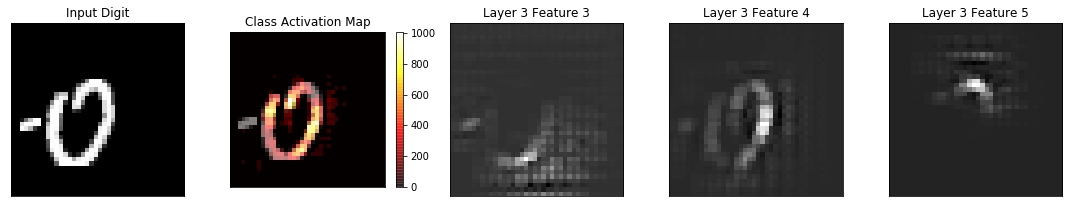

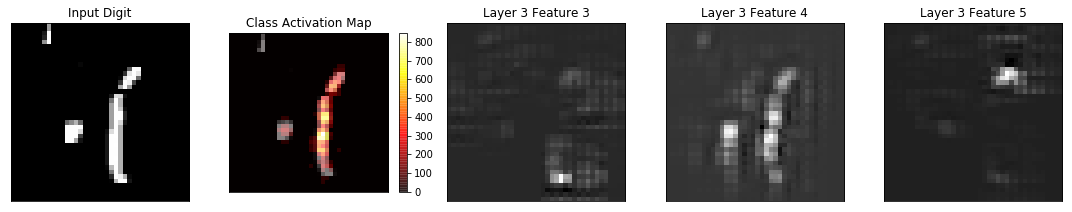

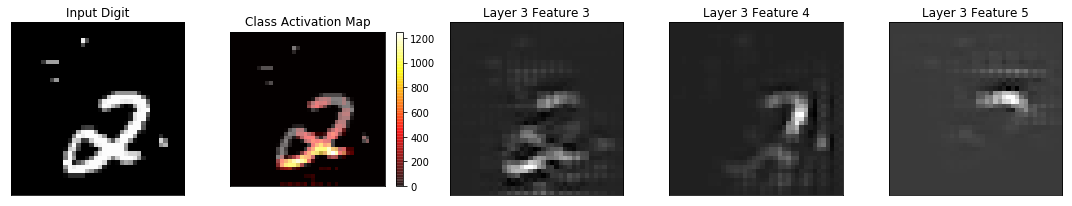

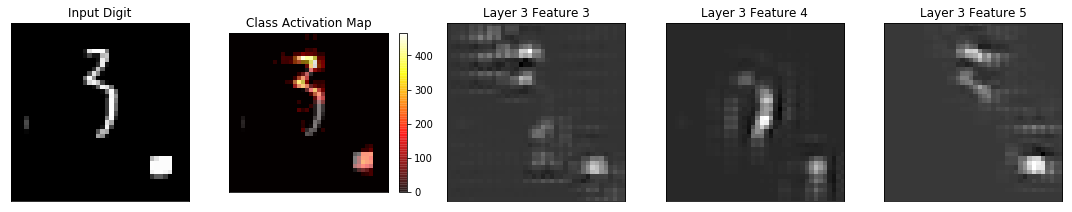

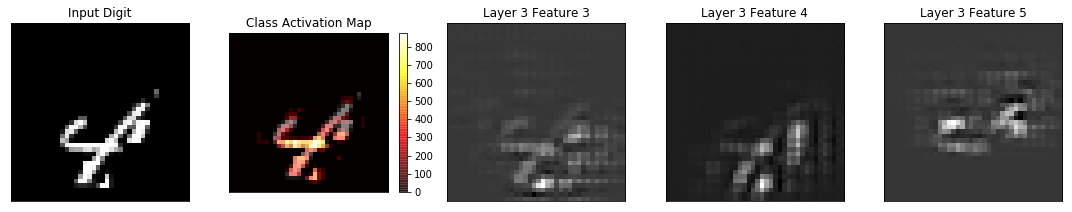

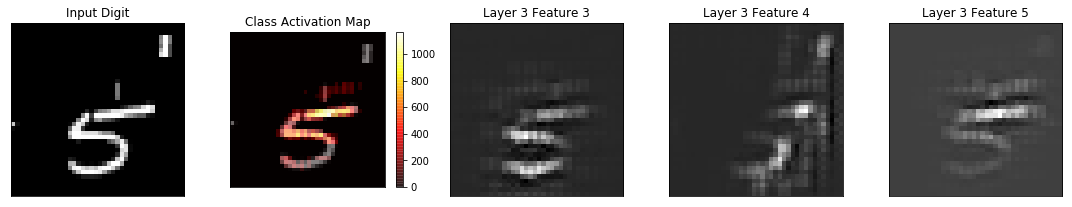

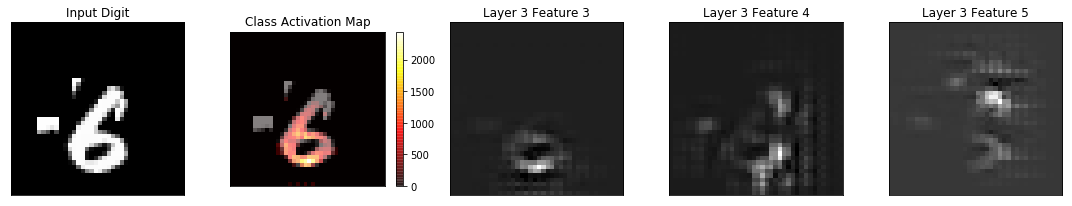

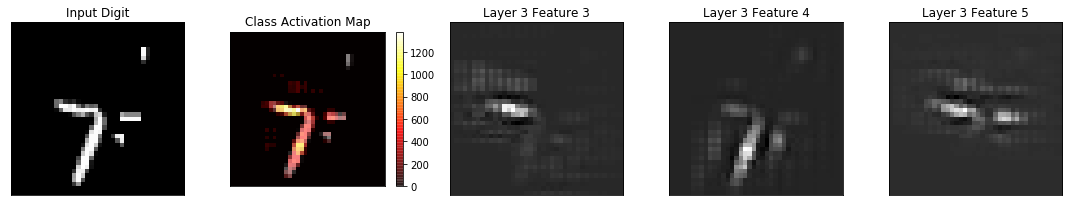

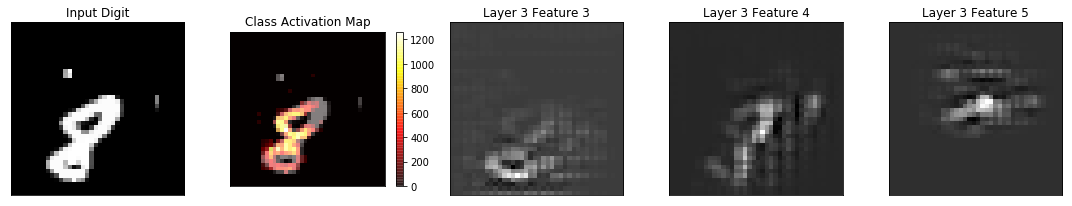

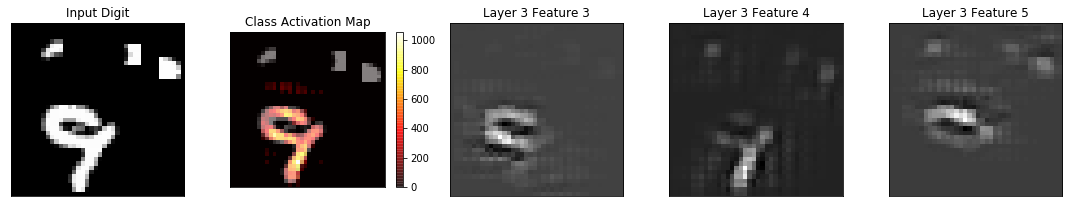

In [6]:
for i in range(10):
    
    fig = plt.figure(figsize=(15,15))
    for j in range(5):

        ax = fig.add_subplot(1, 5, j + 1)

        if j is 0:
            ax.imshow(sample_imgs[i].reshape(40,40), cmap='gray')
            ax.set_title('Input Digit')
        elif j is 1:
            th = (hmaps[i] > np.max(hmaps[i]) * 0.1) * hmaps[i]
            
            ax.imshow(sample_imgs[i].reshape(40,40), cmap='gray')
            im = ax.imshow(th.reshape(40,40), cmap='hot', alpha=0.5)
            ax.set_title('Class Activation Map')
            
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.15)
            plt.colorbar(im, cax=cax)
        else:
            ax.imshow(cams[j][i].reshape(40,40), cmap='gray')
            ax.set_title('Layer 3 Feature {}'.format(j + 1))

        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()